In [1]:
import sys
sys.path.append("..")

is_in_colab = 'google.colab' in sys.modules

if is_in_colab:
  from google.colab import drive
  drive.mount('/content/drive')
  sys.path.insert(0,'/content/drive/MyDrive/nlp_question_answer_project')

  %cd /content/drive/MyDrive/nlp_question_answer_project/notebooks

In [2]:
%%capture
!pip install -r ../requirements.txt

# 1.1 Preprocessing and Dataset Analysis

All the package imports.

In [23]:
from datasets import load_dataset
import pandas as pd
import re
import spacy
from spacy.lang.fi import Finnish
from spacy.lang.en import English
from spacy.lang.ja import Japanese
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex

import stanza

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Pipelines


Spacy pipelines

In [14]:
%%capture
!python -m spacy download en_core_web_lg
!python -m spacy download fi_core_news_lg
!python -m spacy download ja_core_news_lg

     -------------------------------------- 587.7/587.7 MB 1.1 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
     -------------------------------------- 230.8/230.8 MB 2.6 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('fi_core_news_lg')


     -------------------------------------- 555.1/555.1 MB 1.3 MB/s eta 0:00:00
  Using cached SudachiDict-core-20220729.tar.gz (9.1 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 1.0/1.0 MB 2.8 MB/s eta 0:00:00
  Created wheel for sudachidict-core: filename=SudachiDict_core-20220729-py3-none-any.whl size=71570371 sha256=71df1696e0bf1f03470e8b07ad8c69b47d28b7903dc2d71bededbe8f2cbe6f5e
  Stored in directory: c:\users\rasmu\appdata\local\pip\cache\wheels\ff\47\2b\6dcb905d9086fc6f9b7af821f7145f785d36070b827b7f80b7
Successfully built sudachidict-core
[+] Download and installation successful
You can now load the package via spacy.load('ja_core_news_lg')


Stanza pipelines

In [4]:
%%capture
stanza.download('en')
stanza.download('fi')
stanza.download('ja')

2022-10-06 14:19:04 INFO: Downloading default packages for language: en (English) ...
2022-10-06 14:19:16 INFO: Finished downloading models and saved to /home/sollertis/stanza_resources.
2022-10-06 14:19:16 INFO: Downloading default packages for language: fi (Finnish) ...
2022-10-06 14:19:30 INFO: Finished downloading models and saved to /home/sollertis/stanza_resources.
2022-10-06 14:19:30 INFO: Downloading default packages for language: ja (Japanese) ...
2022-10-06 14:19:45 INFO: Finished downloading models and saved to /home/sollertis/stanza_resources.


## Q1.1

Here we define some globals which will be used in Q1.1.

First, lets define the path where the preprocessed data will be stored for later use.
We could get issues if storing the data as CSV after tokenization, since the list of tokens:
"['a'], ['b']", will automatically be converted to a string (since the list contains ',').
So let's store it in pickle format.

In [7]:
path_train_set = "../data/train_set_stanza.pkl"
path_validation_set = "../data/validation_set_stanza.pkl"

## Q1.1a

Let's download the dataset from the web.

In [6]:
%%capture
dataset_raw = load_dataset("copenlu/answerable_tydiqa")

In [19]:
train_set_raw = dataset_raw["train"].to_pandas()
validation_set_raw = dataset_raw["validation"].to_pandas()

Let's also store the dataset for good measures

In [20]:
raw_path_train_set = "../data/raw_train_set.pkl"
raw_path_validation_set = "../data/raw_validation_set.pkl"

In [21]:
train_set_raw = train_set_raw[train_set_raw['language'].isin(["english", "finnish", "japanese"])]
validation_set_raw = validation_set_raw[validation_set_raw['language'].isin(["english", "finnish", "japanese"])]

In [22]:
train_set_raw.to_pickle(raw_path_train_set)
validation_set_raw.to_pickle(raw_path_validation_set)

In [ ]:
train_set_raw.head()

In [ ]:
def print_preprocessing_summary(df):
    num_unanswered = df[df['document_answer_region'] == Annotation_error.UNANSWERED].shape[0]
    num_answered_but_failed = df[df['document_answer_region'] == Annotation_error.BAD_TOKENIZATION_OR_DATA].shape[0]
    num_answered = df.shape[0] - num_answered_but_failed - num_unanswered

    print("[Parsing Info] {} answered questions. {} unanswered questions. Failed to parse {} (answered) questions.".format(num_answered, num_unanswered, num_answered_but_failed))

### Preprocessing with Spacy

Let's do some preprocessing!

In [ ]:
def spacy_custom_tokenizer(nlp):
    infixes = nlp.Defaults.infixes + [r"[\.\,]?\[\S*"]
    infix_re = spacy.util.compile_infix_regex(infixes)
    prefix_re = compile_prefix_regex(nlp.Defaults.prefixes)
    suffix_re = compile_suffix_regex(nlp.Defaults.suffixes)

    return Tokenizer(
        nlp.vocab,
        prefix_search=prefix_re.search,
        suffix_search=suffix_re.search,
        infix_finditer=infix_re.finditer,
        #token_match=nlp.tokenizer.token_match,
        rules=nlp.Defaults.tokenizer_exceptions)

In [ ]:
def spacy_custom_nlp(pipeline_name: str):
    nlp = spacy.load(pipeline_name)
    nlp.tokenizer = spacy_custom_tokenizer(nlp)
    return nlp

In [ ]:
def preprocess_annotation(raw_sample, nlp):
    document_doc = nlp(raw_sample['document_plaintext'])
    annotations = raw_sample['annotations']

    # extract answer annotations
    start = annotations['answer_start'][0]
    if start == -1: # unanswered question
        region = Annotation_error.UNANSWERED
    else:
        length = len(annotations['answer_text'][0])
        end = start + length

        span = document_doc.char_span(start, end) # or None if the span is within a token

        if span == None: # the answer region does not match token boundaries (either due to poor tokenzation or poor data labelling)
            region = Annotation_error.BAD_TOKENIZATION_OR_DATA
        else:
            region = (span.start, span.end)

    return region

def preprocess_language(raw_df, nlp, preprocess_annotations: bool = False, num_max_rows=-1):
    rows = len(raw_df)
    
    if num_max_rows > 0: # @Remove
        rows = min(rows, num_max_rows)
    
    columns = ['language', 'question', 'document_title', 'document', 'document_answer_region']
    df = pd.DataFrame(columns=columns, index=range(rows))
    
    df['language'] = raw_df['language'].iloc[0]
 
    for i in range(rows):
        raw_sample = raw_df.iloc[i]

        df.at[i,'question'] = [t.text for t in nlp(raw_sample['question_text'])]
        df.at[i,'document_title'] = [t.text for t in nlp(raw_sample['document_title'])]
        df.at[i,'document'] = [t.text for t in nlp(raw_sample['document_plaintext'])]
        
        
        if preprocess_annotations:
            answer_region = preprocess_annotation(raw_sample, nlp)
        else:
            answer_region = Annotation_error.IGNORED    
        
        df.at[i,'document_answer_region'] = answer_region
        
        
        if i % 1000  == 0:
            print("sample {}/{}".format(i, rows))
            
        if i == num_max_rows: # @Remove
            break
    
    return df

In [ ]:
def preprocess(raw_data, max_rows_per_language=-1):
    # @Note: how pipelines work in spacy: https://spacy.io/usage/processing-pipelines
    
    # english
    raw_data_en = raw_data[raw_data['language'] == 'english']
    nlp_en = spacy_custom_nlp('en_core_web_lg')
    data_en = preprocess_language(raw_data_en, nlp_en, num_max_rows=max_rows_per_language)
    print_preprocessing_summary(data_en)
    
    # finnish
    raw_data_fi = raw_data[raw_data['language'] == 'finnish']
    nlp_fi = spacy_custom_nlp('fi_core_news_lg')
    data_fi = preprocess_language(raw_data_fi, nlp_fi, num_max_rows=max_rows_per_language)
    print_preprocessing_summary(data_fi)
    
    # japanese
    # @Note: for some reason, the pretrained pipeline doesn't work well with finding the answer. Japenese() works a lot better. However, maybe it just tokenizes each symbol
    raw_data_ja = raw_data[raw_data['language'] == 'japanese']
    nlp_ja = spacy_custom_nlp('ja_core_news_lg')
    data_ja = preprocess_language(raw_data_ja, nlp_ja, num_max_rows=max_rows_per_language) 
    print_preprocessing_summary(data_ja)
    
    # concat
    data = pd.concat([data_en, data_fi, data_ja])
    
    return data


### Preprocessing with Staza

In [ ]:
def preprocess_annotation(raw_sample, nlp):
    doc = nlp(raw_sample['document_plaintext'])
    annotations = raw_sample['annotations']

    # extract answer annotations
    start = annotations['answer_start'][0]
    if start == -1: # unanswered question
        region = Annotation_error.UNANSWERED
    else:
        length = len(annotations['answer_text'][0])
        end = start + length
        
        ids = np.array([token.id for sentence in doc.sentences for token in sentence.tokens])
        start_chars = np.array([token.start_char for sentence in doc.sentences for token in sentence.tokens])
        end_chars = np.array([token.end_char for sentence in doc.sentences for token in sentence.tokens])
        
        start_index = ids[start_chars == start]
        end_index = ids[end_chars == end]
        
        if start_index.shape[0] == 0 or end_index.shape[0] == 0: # the answer region does not match token boundaries (either due to poor tokenzation or poor data labelling)
            region = Annotation_error.BAD_TOKENIZATION_OR_DATA
        else:
            assert(start_index.shape[0] == 1)
            assert(end_index.shape[0] == 1)
            
            region = (start_index[0][0], end_index[0][0])

    return region

def extract_tokens(doc):
    return [token.text for sentence in doc.sentences for token in sentence.tokens]

def preprocess_language(raw_df, nlp, preprocess_annotations: bool = True, num_max_rows=-1):
    rows = len(raw_df)
    
    if num_max_rows > 0: # early terminate for testing
        rows = min(rows, num_max_rows)
    
    columns = ['language', 'question', 'document_title', 'document', 'document_answer_region']
    df = pd.DataFrame(columns=columns, index=range(rows))
    
    df['language'] = raw_df['language'].iloc[0]
 
    for i in range(rows):
        raw_sample = raw_df.iloc[i]

        df.at[i,'question'] = extract_tokens(nlp(raw_sample['question_text']))
        df.at[i,'document_title'] = extract_tokens(nlp(raw_sample['document_title']))
        df.at[i,'document'] = extract_tokens(nlp(raw_sample['document_plaintext']))
        
        if preprocess_annotations:
            answer_region = preprocess_annotation(raw_sample, nlp)
        else:
            answer_region = Annotation_error.IGNORED    
        
        df.at[i,'document_answer_region'] = answer_region
        
        
        if i % 1000  == 0:
            print("sample {}/{}".format(i, rows))
            
        if i == num_max_rows:
            print("early terminating...")
            break
    
    return df

In [ ]:
def preprocess(raw_data, max_rows_per_language=-1):
    # english
    raw_data_en = raw_data[raw_data['language'] == 'english']
    nlp_en = stanza.Pipeline(lang='en', processors='tokenize')
    data_en = preprocess_language(raw_data_en, nlp_en, num_max_rows=max_rows_per_language)
    print_preprocessing_summary(data_en)
    
    # finnish
    raw_data_fi = raw_data[raw_data['language'] == 'finnish']
    nlp_fi = stanza.Pipeline(lang='fi', processors='tokenize')
    data_fi = preprocess_language(raw_data_fi, nlp_fi, num_max_rows=max_rows_per_language)
    print_preprocessing_summary(data_fi)
    
    # japanese
    raw_data_ja = raw_data[raw_data['language'] == 'japanese']
    nlp_ja = stanza.Pipeline(lang='ja', processors='tokenize')
    data_ja = preprocess_language(raw_data_ja, nlp_ja, num_max_rows=max_rows_per_language) 
    print_preprocessing_summary(data_ja)
    
    # concat
    data = pd.concat([data_en, data_fi, data_ja])
    
    return data


Let's preprocess the training data

In [ ]:
train_set = preprocess(train_set_raw, max_rows_per_language = -1)

In [ ]:
train_set.head()

Let's preprocess the validation data

In [ ]:
validation_set = preprocess(validation_set_raw, max_rows_per_language=-1)

In [ ]:
validation_set.head()

### Save pre-processed training and validation data

In [ ]:
train_set.to_pickle(path_train_set)

In [ ]:
validation_set.to_pickle(path_validation_set)

### Load pre-processed training and validation data

In [8]:
train_set = pd.read_pickle(path_train_set)
validation_set = pd.read_pickle(path_validation_set)

In [9]:
train_set.head()

,language,question,document_title,document,document_answer_region
0,english,"[When, was, quantum, field, theory, developed, ?]","[Quantum, field, theory]","[Quantum, field, theory, naturally, began, wit...","(26, 26)"
1,english,"[Who, was, the, first, Nobel, prize, winner, f...","[List, of, Nobel, laureates, in, Literature]","[The, Nobel, Prize, in, Literature, (, Swedish...","(12, 13)"
2,english,"[When, is, the, dialectical, method, used, ?]",[Dialectic],"[Dialectic, or, dialectics, (, Greek, :, διαλε...","(27, 49)"
3,english,"[Who, invented, Hangul, ?]","[Origin, of, Hangul]","[Hangul, was, personally, created, and, promul...","(16, 18)"
4,english,"[What, do, Grasshoppers, eat, ?]",[Grasshopper],"[Grasshoppers, are, plant, -, eaters, ,, with,...","(1, 37)"


In [10]:
validation_set.head()

,language,question,document_title,document,document_answer_region
0,english,"[What, is, a, way, to, increase, your, wound, ...","[Wound, healing]","[Wound, care, encourages, and, speeds, wound, ...","(9, 15)"
1,english,"[Who, founded, the, Burntisland, Shipbuilding,...","[Burntisland, Shipbuilding, Company]","[Brothers, Amos, and, Wilfrid, Ayre, founded, ...","(1, 5)"
2,english,"[What, is, the, surface, area, of, the, human,...","[Cerebral, cortex]","[For, species, of, mammals, ,, larger, brains,...","(35, 38)"
3,english,"[When, did, the, case, of, R, (, Factortame, L...","[R, (, Factortame, Ltd, ), v, Secretary, of, S...","[As, from, 31, March, 1989, ,, fishing, vessel...","(37, 38)"
4,english,"[When, was, Quezon, City, founded, ?]","[Quezon, City]","[When, Quezon, City, was, created, in, 1939, ,...","(7, 7)"


Just to make it easier to reference the training data onwards.

In [11]:
train_en = train_set[train_set["language"] == "english"]
train_fi = train_set[train_set["language"] == "finnish"]
train_ja = train_set[train_set["language"] == "japanese"]

In [12]:
validation_en = validation_set[validation_set["language"] == "english"]
validation_fi = validation_set[validation_set["language"] == "finnish"]
validation_ja = validation_set[validation_set["language"] == "japanese"]

## Q1.1b

Let's plot the most common start and end words of each question.

In [35]:
def plot_most_common_words(words, title, top=-1, font_prop=None, rotation=45):
    # @TODO: add subtitle/translation for x-axis (zip)
    uniques, uniques_counts = np.unique(words, return_counts=True)
    index_sorted = np.argsort(uniques_counts, axis=None)[::-1]
    
    if top > 0:
        index_sorted = index_sorted[:top]
    
    uniques_counts_percentage = uniques_counts / np.sum(uniques_counts) * 100
    
    fig, ax = plt.subplots(figsize=(15,6))
    ax.grid(linestyle="--")
    ax.set_title(title)
    ax.set_ylabel("Percentage (%)")
    
    ticks = range(len(index_sorted))
    ax.bar(ticks, uniques_counts_percentage[index_sorted])
    ax.set_xticks(ticks, uniques[index_sorted], rotation=rotation, fontproperties=font_prop)    

In [24]:
def get_all_Nth_tokens(df_tokens, n):
    return df_tokens.map(lambda tokens: tokens[n])

def get_firsts(df_tokens):
    return get_all_Nth_tokens(df_tokens, 0)

def get_lasts(df_tokens):
    return get_all_Nth_tokens(df_tokens, -1)

### English trainset summary 

In [25]:
df_question = train_en["question"]

firsts = get_firsts(df_question)
lasts = get_lasts(df_question)

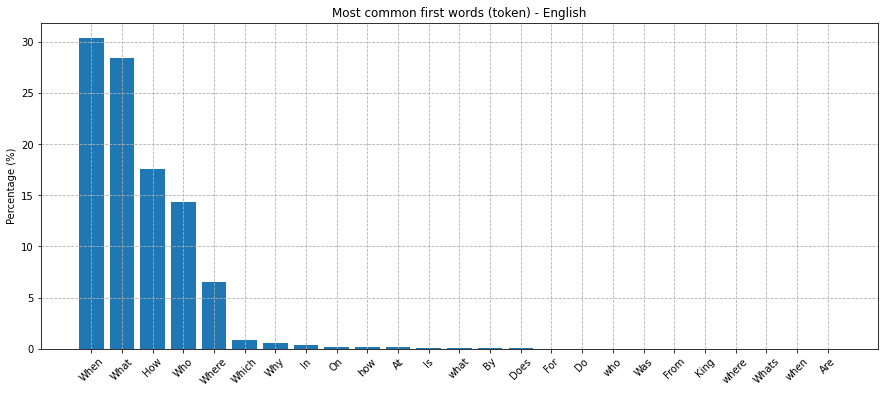

In [26]:
plot_most_common_words(firsts, "Most common first words (token) - English", top=25)

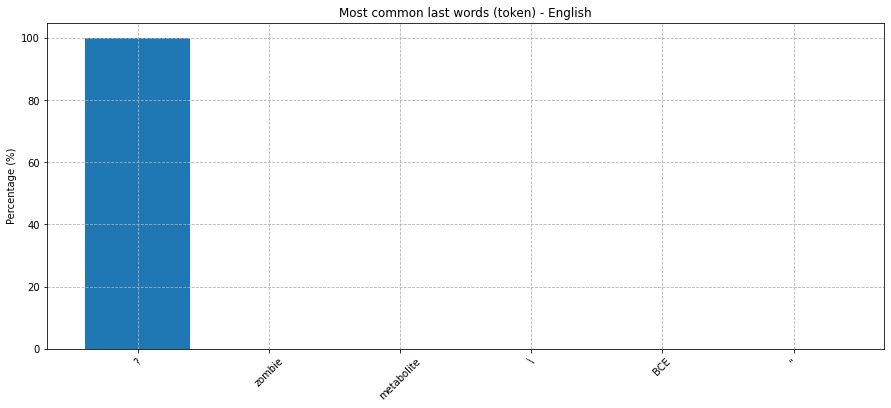

In [27]:
plot_most_common_words(lasts, "Most common last words (token) - English", top=25)

### Finnish trainset summary 

In [28]:
df_question = train_fi["question"]

firsts = get_firsts(df_question)
lasts = get_lasts(df_question)

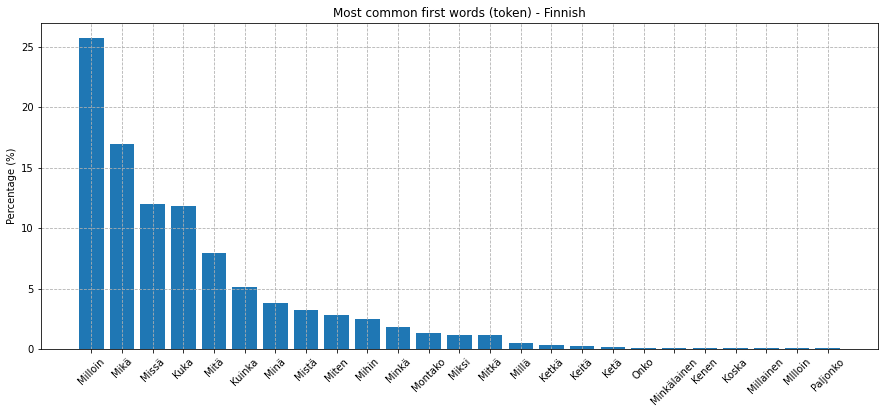

In [29]:
plot_most_common_words(firsts, "Most common first words (token) - Finnish", top=25)

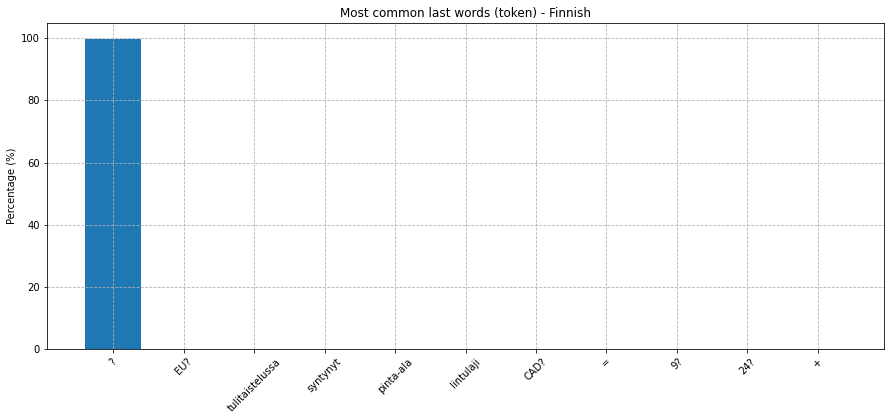

In [30]:
plot_most_common_words(lasts, "Most common last words (token) - Finnish", top=25)

### Japanese trainset summary 

Use a font which supports japanese characters.

In [31]:
import matplotlib.font_manager as fm
fprop = fm.FontProperties(fname='../resources/Osaka.ttc')

In [32]:
df_question = train_ja["question"]

firsts = get_firsts(df_question)
lasts = get_lasts(df_question)

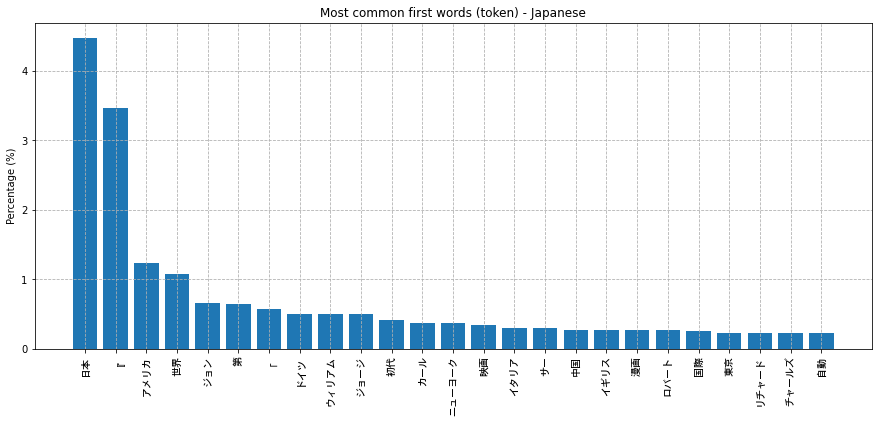

In [33]:
plot_most_common_words(firsts, "Most common first words (token) - Japanese", top=25, font_prop=fprop, rotation=90)

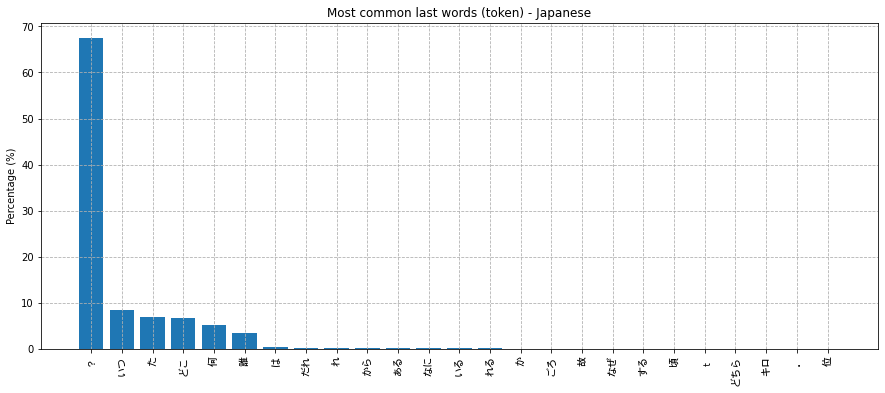

In [34]:
plot_most_common_words(lasts, "Most common last words (token) - Japanese", top=25, font_prop=fprop, rotation=90)